In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import tensorflow as tf
import tensorflow.keras as keras


## Data Loading

In [2]:
#batting_data = pd.read_excel("./raw_data/domestic/australia/batting.xlsx")
#bowling_data = pd.read_excel("./raw_data/domestic/australia/bowling.xlsx")
#matches_data = pd.read_excel("./raw_data/domestic/australia/matches.xlsx")
#players_data = pd.read_excel("./raw_data/domestic/australia/players_with_teams.xlsx")

In [3]:
batting_file = "./raw_data/domestic/australia/batting.xlsx"
bowling_file = "./raw_data/domestic/australia/bowling.xlsx"
matches_file = "./raw_data/domestic/australia/matches.xlsx"
players_file = "./raw_data/domestic/australia/players_with_teams.xlsx"

In [4]:
batting_data = pd.read_excel(batting_file)
bowling_data = pd.read_excel(bowling_file)
matches_data = pd.read_excel(matches_file)
players_data = pd.read_excel(players_file)

In [5]:
batting_data.to_parquet(batting_file[:-4]+"parquet")
bowling_data.to_parquet(bowling_file[:-4]+"parquet")
matches_data.to_parquet(matches_file[:-4]+"parquet")
players_data.to_parquet(players_file[:-4]+"parquet")

In [6]:
batting_data = pd.read_parquet(batting_file[:-4]+"parquet")
bowling_data = pd.read_parquet(bowling_file[:-4]+"parquet")
matches_data = pd.read_parquet(matches_file[:-4]+"parquet")
players_data = pd.read_parquet(players_file[:-4]+"parquet")

## Preprocessing and Cleaning

In [7]:
players_data['Age'] = players_data['Age'].replace(np.nan, None)

In [8]:
ages = players_data['Age'].apply(lambda x: re.search(r'(\d*)y', x).group(1) if x is not None else '0')

ages = ages.astype(int)

players_data['Age'] = ages
players_data = players_data.drop(players_data['Age'][players_data['Age'] == 0].index).reset_index(drop=True)
players_data = players_data.drop(players_data['Age'][players_data['Age'] >= 55].index).reset_index(drop=True)



In [9]:
players_data = players_data[players_data['Playing Role'].notna()].reset_index(drop=True)

players = players_data['Player URL'].unique()

ids = np.arange(len(players))

player_ids = dict(zip(players, ids))

In [10]:
players_data['Player ID'] = players_data['Player URL'].apply(lambda x: player_ids[x])

In [11]:
batting_data['Player ID'] = batting_data['Player URL'].apply(lambda x: player_ids[x] if x in player_ids.keys() else np.nan)

In [12]:
batting_data = batting_data[batting_data['Player ID'].notna()].reset_index(drop=True)

In [13]:
batting_data['Player ID'] = batting_data['Player ID'].astype(int)

In [14]:
bowling_data['Player ID'] = bowling_data['Player URL'].apply(lambda x: player_ids[x] if x in player_ids.keys() else np.nan)

In [15]:
bowling_data = bowling_data[bowling_data['Player ID'].notna()].reset_index(drop=True)

In [16]:
bowling_data['Player ID'] = bowling_data['Player ID'].astype(int)

In [17]:
batting_data[batting_data['Player ID'].notna()].shape, batting_data['Player ID'].shape

((6602, 18), (6602,))

In [18]:
batting_data = batting_data[batting_data['Player ID'].notna()].reset_index(drop=True)
bowling_data = bowling_data[bowling_data['Player ID'].notna()].reset_index(drop=True)


In [19]:
batting_data.head(5)

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/james-smit...,c †Triffitt b Maher,3,6,-,0,0,50.00,James Smith,2,lbw b Maher,8,22,-,0,0,36.36,107
1,https://www.espncricinfo.com/player/michael-kl...,c Cowan b Hilfenhaus,14,35,-,2,0,40.00,Michael Klinger,2,c †Triffitt b Hilfenhaus,1,6,-,0,0,16.66,164
2,https://www.espncricinfo.com/player/tom-moffat...,c †Triffitt b Faulkner,36,120,-,4,0,30.00,Tom Moffat,2,lbw b Maher,0,5,-,0,0,0.00,231
3,https://www.espncricinfo.com/player/aiden-bliz...,c †Triffitt b Doherty,15,53,-,2,0,28.30,Aiden Blizzard,2,b Hilfenhaus,11,12,-,2,0,91.66,5
4,https://www.espncricinfo.com/player/graham-man...,b Maher,82,149,-,7,0,55.03,Graham Manou,2,b Maher,18,18,-,4,0,100.00,78


In [20]:
matches_data.head(5)

,Match URL,Match ID,MoM,Meta,Result,Ground URL,Ground Name,Toss,Series,Season,...,Match days,FC debut,Umpires,Match Referee,Points,Series result,TV Umpire,Player Replacement,Reserve Umpire,Player Of The Series
0,https://www.espncricinfo.com/series/sheffield-...,2,https://www.espncricinfo.com/player/nick-kruge...,"Adelaide, March 10 - 13, 2011",Tasmania won by 4 wickets,https://www.espncricinfo.com/ci/content/ground...,Adelaide Oval,"South Australia, elected to bat first",Sheffield Shield,2010/11,...,"10,11,12,13 March 2011",NaN,Ian Lock,David Levens,"Tasmania 6, South Australia 2",None,None,None,None,None
1,https://www.espncricinfo.com/series/sheffield-...,7,https://www.espncricinfo.com/player/nick-kruge...,"Hobart, March 03 - 05, 2011",Tasmania won by an innings and 70 runs,https://www.espncricinfo.com/ci/content/ground...,"Bellerive Oval, Hobart","Tasmania, elected to field first",Sheffield Shield,2010/11,...,"3,4,5 March 2011",NaN,Geoff Joshua,Ric Evans,"Tasmania 6, New South Wales 0",None,None,None,None,None
2,https://www.espncricinfo.com/series/sheffield-...,8,https://www.espncricinfo.com/player/luke-butte...,"Perth, February 21 - 23, 2011",Tasmania won by an innings and 129 runs,https://www.espncricinfo.com/ci/content/ground...,"Western Australia Cricket Association Ground, ...","Western Australia, elected to bat first",Sheffield Shield,2010/11,...,"21,22,23 February 2011",NaN,Johan Cloete,Sean Cary,"Tasmania 6, Western Australia 0",None,None,None,None,None
3,https://www.espncricinfo.com/series/sheffield-...,4,https://www.espncricinfo.com/player/phillip-hu...,"Sydney, March 10 - 13, 2011",NSW won by 3 wickets,https://www.espncricinfo.com/ci/content/ground...,Sydney Cricket Ground,"Western Australia, elected to bat first",Sheffield Shield,2010/11,...,"10,11,12,13 March 2011",NaN,Gerard Abood,Steve Small,"New South Wales 6, Western Australia 2",None,None,None,None,None
4,https://www.espncricinfo.com/series/sheffield-...,5,https://www.espncricinfo.com/player/marcus-har...,"Perth, March 03 - 06, 2011",West Aust won by 7 wickets,https://www.espncricinfo.com/ci/content/ground...,"Western Australia Cricket Association Ground, ...","Western Australia, elected to field first",Sheffield Shield,2010/11,...,"3,4,5,6 March 2011",NaN,Ian Lock,Steve Small,"Western Australia 6, Queensland 0",None,None,None,None,None


In [21]:
players_data.head(5)

,Player URL,Full Name,Born,Age,Nicknames,Batting Style,Bowling Style,Playing Role,Height,Team URL,Team Name,All teams,Fielding Position,RELATIONS,Education,Died,Other,Also Known As,Player ID
0,https://www.espncricinfo.com/player/aaron-heal...,Aaron Keith Heal,"March 13, 1983, Armadale, Perth, Western Austr...",39,Heals,Left hand Bat,Slow Left arm Orthodox,Bowler,1.83 m,https://www.espncricinfo.com/team/melbourne-re...,Melbourne Renegades,"Melbourne Renegades,Western Australia",None,NaN,None,None,None,None,0
1,https://www.espncricinfo.com/player/aaron-hard...,Aaron Mark Hardie,"January 07, 1999, Bournemouth, Dorset",23,None,Right hand Bat,Right arm Medium fast,Allrounder,None,https://www.espncricinfo.com/team/australia-un...,Australia Under-19s,"Australia Under-19s,Perth Scorchers,Western Au...",None,NaN,None,None,None,None,1
2,https://www.espncricinfo.com/player/adam-crost...,Adam John Crosthwaite,"September 22, 1984, Mercy Hospital, Melbourne,...",37,Skinny,Right hand Bat,Legbreak Googly,Middle order Batter,1.81 m,https://www.espncricinfo.com/team/adelaide-str...,Adelaide Strikers,"Adelaide Strikers,South Australia,Victoria",Wicketkeeper,NaN,None,None,None,None,2
3,https://www.espncricinfo.com/player/aaron-finc...,Aaron James Finch,"November 17, 1986, Colac, Victoria",35,Finchy,Right hand Bat,Slow Left arm Orthodox,Top order Batter,1.74 m,https://www.espncricinfo.com/team/australia-2,Australia,"Australia,AJ Finch's XI,Auckland,Australia A,A...",None,NaN,None,None,None,None,3
4,https://www.espncricinfo.com/player/adam-voges...,Adam Charles Voges,"October 04, 1979, Subiaco, Perth, Western Aust...",42,"Kenny, Hank",Right hand Bat,Slow Left arm Orthodox,Top order Batter,1.85 m,https://www.espncricinfo.com/team/australia-2,Australia,"Australia,Australia A,Hampshire,Jamaica Tallaw...",None,NaN,None,None,None,None,4


## Process batting data

In [22]:
batting_data["Wicket"] = batting_data["Wicket"].fillna("didnt play")
wickets = batting_data["Wicket"].apply(lambda x: re.search(r'[c,b]\s', x).group() if re.search(r'[c,b]\s', x) else x)
wickets = wickets.apply(lambda x: re.search(r'run out', x).group() if re.search(r'run out', x) else x)
wickets = wickets.apply(lambda x: re.search(r'not out', x).group() if re.search(r'not out', x) else x)
wickets = wickets.apply(lambda x: re.search(r'lbw', x).group() if re.search(r'lbw', x) else x)
wickets = wickets.apply(lambda x: x.strip())

batting_data["Wicket"] = wickets

In [23]:
batting_data.columns

Index(['Player URL', 'Wicket', 'R', 'B', 'M', '4s', '6s', 'SR', 'Player Name',
       'Match ID', 'Wicket_2', 'R_2', 'B_2', 'M_2', '4s_2', '6s_2', 'SR_2',
       'Player ID'],
      dtype='object')

In [24]:
batting_data["Wicket_2"] = batting_data["Wicket_2"].fillna("didnt play")

wickets_2 = batting_data["Wicket_2"].apply(lambda x: re.search(r'[c,b]\s', x).group() if re.search(r'[c,b]\s', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'run out', x).group() if re.search(r'run out', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'not out', x).group() if re.search(r'not out', x) else x)
wickets_2 = wickets_2.apply(lambda x: re.search(r'lbw', x).group() if re.search(r'lbw', x) else x)
wickets_2 = wickets_2.apply(lambda x: x.strip())

batting_data["Wicket_2"] = wickets_2

In [25]:
batting_data[['R','B', 'M', 'SR', '4s', '6s', 'R_2','B_2', 'M_2', 'SR_2', '4s_2', '6s_2']] = batting_data[['R','B', 'M', 'SR', '4s', '6s', 'R_2','B_2', 'M_2', 'SR_2', '4s_2', '6s_2']].replace('-', 0).astype(np.float32)

In [26]:
batting_data

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/james-smit...,c,3.0,6.0,0.0,0.0,0.0,50.000000,James Smith,2,b,8.0,22.0,0.0,0.0,0.0,36.360001,107
1,https://www.espncricinfo.com/player/michael-kl...,c,14.0,35.0,0.0,2.0,0.0,40.000000,Michael Klinger,2,c,1.0,6.0,0.0,0.0,0.0,16.660000,164
2,https://www.espncricinfo.com/player/tom-moffat...,c,36.0,120.0,0.0,4.0,0.0,30.000000,Tom Moffat,2,b,0.0,5.0,0.0,0.0,0.0,0.000000,231
3,https://www.espncricinfo.com/player/aiden-bliz...,c,15.0,53.0,0.0,2.0,0.0,28.299999,Aiden Blizzard,2,b,11.0,12.0,0.0,2.0,0.0,91.660004,5
4,https://www.espncricinfo.com/player/graham-man...,b,82.0,149.0,0.0,7.0,0.0,55.029999,Graham Manou,2,b,18.0,18.0,0.0,4.0,0.0,100.000000,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597,https://www.espncricinfo.com/player/jake-lehma...,c,12.0,16.0,20.0,2.0,0.0,75.000000,Jake Lehmann,359,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,97
6598,https://www.espncricinfo.com/player/nathan-mca...,not out,65.0,80.0,100.0,7.0,2.0,81.250000,Nathan McAndrew,359,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,175
6599,https://www.espncricinfo.com/player/daniel-wor...,b,2.0,2.0,2.0,0.0,0.0,100.000000,Daniel Worrall,359,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,65
6600,https://www.espncricinfo.com/player/david-gran...,c,4.0,13.0,14.0,1.0,0.0,30.760000,David Grant,359,didnt play,NaN,NaN,NaN,NaN,NaN,NaN,69


In [27]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_cols = batting_data.select_dtypes(include=numerics).columns

batting_data[num_cols] = batting_data[num_cols].fillna(0)

batting_data

,Player URL,Wicket,R,B,M,4s,6s,SR,Player Name,Match ID,Wicket_2,R_2,B_2,M_2,4s_2,6s_2,SR_2,Player ID
0,https://www.espncricinfo.com/player/james-smit...,c,3.0,6.0,0.0,0.0,0.0,50.000000,James Smith,2,b,8.0,22.0,0.0,0.0,0.0,36.360001,107
1,https://www.espncricinfo.com/player/michael-kl...,c,14.0,35.0,0.0,2.0,0.0,40.000000,Michael Klinger,2,c,1.0,6.0,0.0,0.0,0.0,16.660000,164
2,https://www.espncricinfo.com/player/tom-moffat...,c,36.0,120.0,0.0,4.0,0.0,30.000000,Tom Moffat,2,b,0.0,5.0,0.0,0.0,0.0,0.000000,231
3,https://www.espncricinfo.com/player/aiden-bliz...,c,15.0,53.0,0.0,2.0,0.0,28.299999,Aiden Blizzard,2,b,11.0,12.0,0.0,2.0,0.0,91.660004,5
4,https://www.espncricinfo.com/player/graham-man...,b,82.0,149.0,0.0,7.0,0.0,55.029999,Graham Manou,2,b,18.0,18.0,0.0,4.0,0.0,100.000000,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597,https://www.espncricinfo.com/player/jake-lehma...,c,12.0,16.0,20.0,2.0,0.0,75.000000,Jake Lehmann,359,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,97
6598,https://www.espncricinfo.com/player/nathan-mca...,not out,65.0,80.0,100.0,7.0,2.0,81.250000,Nathan McAndrew,359,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,175
6599,https://www.espncricinfo.com/player/daniel-wor...,b,2.0,2.0,2.0,0.0,0.0,100.000000,Daniel Worrall,359,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,65
6600,https://www.espncricinfo.com/player/david-gran...,c,4.0,13.0,14.0,1.0,0.0,30.760000,David Grant,359,didnt play,0.0,0.0,0.0,0.0,0.0,0.000000,69


## Process matches data

In [28]:
match_ids = batting_data['Match ID'].unique()
match_ids = np.unique(np.concatenate((match_ids, bowling_data['Match ID'].unique())))

match_ids

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [29]:
matches_data = matches_data[matches_data['Match ID'].apply(lambda x: x in match_ids)].reset_index(drop=True)

In [30]:
matches_data

,Match URL,Match ID,MoM,Meta,Result,Ground URL,Ground Name,Toss,Series,Season,...,Match days,FC debut,Umpires,Match Referee,Points,Series result,TV Umpire,Player Replacement,Reserve Umpire,Player Of The Series
0,https://www.espncricinfo.com/series/sheffield-...,2,https://www.espncricinfo.com/player/nick-kruge...,"Adelaide, March 10 - 13, 2011",Tasmania won by 4 wickets,https://www.espncricinfo.com/ci/content/ground...,Adelaide Oval,"South Australia, elected to bat first",Sheffield Shield,2010/11,...,"10,11,12,13 March 2011",NaN,Ian Lock,David Levens,"Tasmania 6, South Australia 2",None,None,None,None,None
1,https://www.espncricinfo.com/series/sheffield-...,7,https://www.espncricinfo.com/player/nick-kruge...,"Hobart, March 03 - 05, 2011",Tasmania won by an innings and 70 runs,https://www.espncricinfo.com/ci/content/ground...,"Bellerive Oval, Hobart","Tasmania, elected to field first",Sheffield Shield,2010/11,...,"3,4,5 March 2011",NaN,Geoff Joshua,Ric Evans,"Tasmania 6, New South Wales 0",None,None,None,None,None
2,https://www.espncricinfo.com/series/sheffield-...,8,https://www.espncricinfo.com/player/luke-butte...,"Perth, February 21 - 23, 2011",Tasmania won by an innings and 129 runs,https://www.espncricinfo.com/ci/content/ground...,"Western Australia Cricket Association Ground, ...","Western Australia, elected to bat first",Sheffield Shield,2010/11,...,"21,22,23 February 2011",NaN,Johan Cloete,Sean Cary,"Tasmania 6, Western Australia 0",None,None,None,None,None
3,https://www.espncricinfo.com/series/sheffield-...,4,https://www.espncricinfo.com/player/phillip-hu...,"Sydney, March 10 - 13, 2011",NSW won by 3 wickets,https://www.espncricinfo.com/ci/content/ground...,Sydney Cricket Ground,"Western Australia, elected to bat first",Sheffield Shield,2010/11,...,"10,11,12,13 March 2011",NaN,Gerard Abood,Steve Small,"New South Wales 6, Western Australia 2",None,None,None,None,None
4,https://www.espncricinfo.com/series/sheffield-...,5,https://www.espncricinfo.com/player/marcus-har...,"Perth, March 03 - 06, 2011",West Aust won by 7 wickets,https://www.espncricinfo.com/ci/content/ground...,"Western Australia Cricket Association Ground, ...","Western Australia, elected to field first",Sheffield Shield,2010/11,...,"3,4,5,6 March 2011",NaN,Ian Lock,Steve Small,"Western Australia 6, Queensland 0",None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,https://www.espncricinfo.com/series/sheffield-...,352,https://www.espncricinfo.com/player/scott-bola...,"8th Match, Melbourne, November 05 - 08, 2021",Victoria won by 174 runs,https://www.espncricinfo.com/ci/content/ground...,Melbourne Cricket Ground,"New South Wales, elected to field first",Sheffield Shield,2021/22,...,"5,6,7,8 November 2021",NaN,Phillip Gillespie,Bob Parry,"Victoria 8.01, New South Wales 0.8",None,None,Wil Parker,None,None
350,https://www.espncricinfo.com/series/sheffield-...,356,https://www.espncricinfo.com/player/lawrence-n...,"4th Match, Perth, October 17 - 20, 2021",Tasmania won by 3 wickets,https://www.espncricinfo.com/ci/content/ground...,"Western Australia Cricket Association Ground, ...","Tasmania, elected to field first",Sheffield Shield,2021/22,...,"17,18,19,20 October 2021",NaN,Michael Graham-Smith,David Johnston,"Tasmania 7.52, Western Australia 1.38",None,None,Riley Meredith,None,None
351,https://www.espncricinfo.com/series/sheffield-...,358,https://www.espncricinfo.com/player/tim-ward-1...,"2nd Match, Adelaide, October 07 - 10, 2021",Match drawn,https://www.espncricinfo.com/ci/content/ground...,"Karen Rolton Oval, Adelaide","Tasmania, elected to bat first",Sheffield Shield,2021/22,...,"7,8,9,10 October 2021",NaN,Darren Close,Simon Fry,"Tasmania 2.32, Queensland 2.43",None,None,None,None,None
352,https://www.espncricinfo.com/series/sheffield-...,357,https://www.espncricinfo.com/player/mark-steke...,"3rd Match, Adelaide, October 15 - 18, 2021",Match drawn,https://www.espncricinfo.com/ci/content/ground...

In [31]:
matches_data = matches_data[matches_data['Result'].notna()].reset_index(drop=True)

In [32]:
results = matches_data['Result'].apply(lambda x: re.match(r'(.*) won.*', x).group(1) if re.match(r'.* won.*', x) else x)
results = results.apply(lambda x: 'Draw' if x.strip() == "Match drawn" else x)
results = results.apply(lambda x: None if re.match(r'.*refused.*', x) else x)

In [33]:
matches_data['Result'] = results

In [34]:
matches_data = matches_data[matches_data['Result'].notna()].reset_index(drop=True)

In [35]:
matches_data['MoM'] = matches_data['MoM'].apply(lambda x: player_ids[x] if x in player_ids.keys() else None)

In [36]:
matches_data['Meta']

0                     Adelaide, March 10 - 13, 2011
1                       Hobart, March 03 - 05, 2011
2                     Perth, February 21 - 23, 2011
3                       Sydney, March 10 - 13, 2011
4                        Perth, March 03 - 06, 2011
                           ...                     
349    8th Match, Melbourne, November 05 - 08, 2021
350         4th Match, Perth, October 17 - 20, 2021
351      2nd Match, Adelaide, October 07 - 10, 2021
352      3rd Match, Adelaide, October 15 - 18, 2021
353    1st Match, Adelaide, September 24 - 27, 2021
Name: Meta, Length: 354, dtype: object

In [37]:
','.join(map(str, ['a' , 'asdas']))

'a,asdas'

In [38]:
str_dates = matches_data['Meta'].apply(lambda x: ','.join(map(str, x.split(",")[-2:])))

In [39]:
re_dates = str_dates.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d) - \d\d, (\d\d\d\d)', x) if re.match(r' \w.* \d\d - \d\d, \d\d\d\d', x) else x)
dates_1 = re_dates.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [40]:
re_dates_2 = dates_1.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d), (\d\d\d\d)', x) if re.match(r' ([A-Z,a-z]*) (\d\d), (\d\d\d\d) - .*', x) else x)
dates_2 = re_dates_2.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [41]:
re_dates_3 = dates_2.apply(lambda x: re.match(r' ([A-Z,a-z]*) (\d\d) - [A-Z,a-z]* \d\d, (\d\d\d\d)', x) if re.match(r' ([A-Z,a-z]*) (\d\d) - [A-Z,a-z]* \d\d, (\d\d\d\d)', x) else x)
dates_3 = re_dates_3.apply(lambda x: x.group(1) + "," + x.group(2) + "," + x.group(3) if isinstance(x, re.Match) else x)

In [42]:
matches_data['Date'] = dates_3.apply(lambda x: datetime.strptime(x, "%B,%d,%Y") )

In [43]:
matches_data['Toss Won'] = matches_data['Toss'].apply(lambda x: x.strip().split(',')[0])

In [44]:
matches_data = matches_data[matches_data['Toss'] != 'no toss'].reset_index(drop=True)

In [45]:
matches_data['Toss Selection'] = matches_data['Toss'].apply(lambda x: x.strip().split(',')[1].split(' ')[3])

In [46]:
matches_data.to_excel("results/domestic/australia/matches.xlsx", index=False)

In [47]:
players_data.to_excel("results/domestic/australia/players.xlsx", index=False)

['Allrounder' 'Batter' 'Batting Allrounder' 'Bowler' 'Bowling Allrounder'
 'Middle order Batter' 'Opening Batter' 'Top order Batter' 'Wicketkeeper'
 'Wicketkeeper Batter']


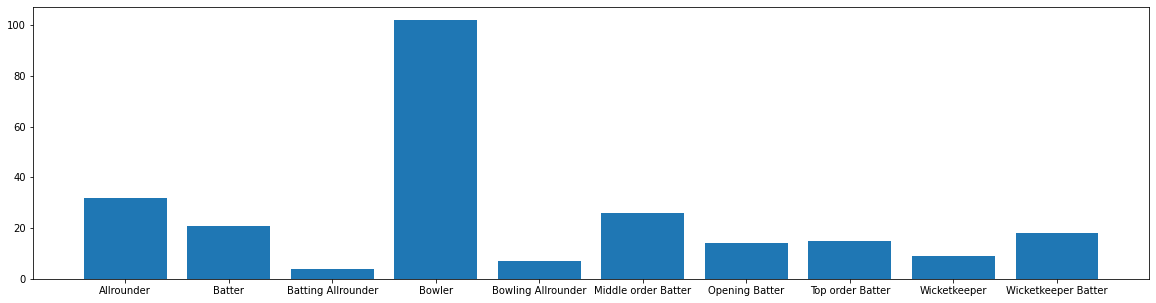

In [48]:
roles, counts = np.unique(players_data['Playing Role'], return_counts=True)

plt.figure(figsize=(20, 5)), plt.bar(roles, counts)
print(roles)

In [49]:
role_data = {}
batting_roles = roles[roles != "Bowler"]
for role in batting_roles:
    ids = players_data[players_data['Playing Role'].apply(lambda x: x == role)]['Player ID'].values
    count = batting_data['Player ID'].apply(lambda x: x in ids).values.sum()
    role_data[role] = count
    
    


(<Figure size 1440x360 with 1 Axes>, <BarContainer object of 9 artists>)

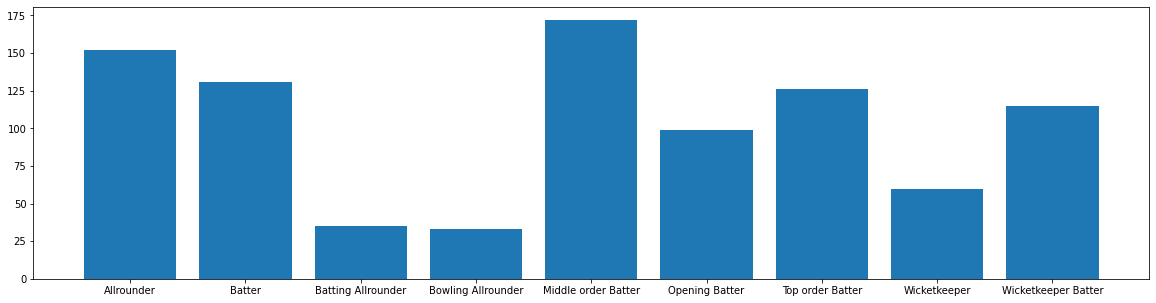

In [50]:
plt.figure(figsize=(20, 5)), plt.bar(role_data.keys(), np.array(list(role_data.values()))//5)


In [51]:
player_teams = {}
for i in range(len(players_data)):
    player_teams[players_data.iloc[i]['Player ID']] = players_data.iloc[i]['Team Name']

In [52]:
json_data = dict()
for k, v in player_teams.items():
    json_data[str(k)] = v

In [53]:

with open("results/domestic/australia/player_teams.json", "w") as fp:
    json.dump(json_data, fp)

In [54]:
match_results = {}
for i in range(len(matches_data)):
    match_results[matches_data.iloc[i]['Match ID']] = [matches_data.iloc[i]['Result'], matches_data.iloc[i]['MoM'], matches_data.iloc[i]['Date'], matches_data.iloc[i]['Toss Won'], matches_data.iloc[i]['Toss Selection']]


## Batsman Model

In [55]:
batting_data['Team'] = "None"
batting_data['Team'] = batting_data['Player ID'].apply(lambda x: player_teams[x])

In [56]:
def match_result(match_id, team):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][0] == team:
        return "Won"
    if match_results[match_id][0] == "Draw":
        return "Draw"
    return "Lost"

In [57]:
def is_mom(match_id, player_id):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][1] == player_id:
        return 1
    return 0

In [58]:
def is_chase(match_id, team):
    result, mom, date, toss_won, toss_selection = match_results[match_id]
    if match_id not in match_results.keys():
        return None
    if team == toss_won and toss_selection == 'field':
        return 1
    if team == toss_won and toss_selection == 'bat':
        return 0
    if team != toss_won and toss_selection == 'field':
        return 0
    if team != toss_won and toss_selection == 'bat':
        return 1
        

In [59]:
def hundred_1(row):
     if row['R'] >= 100:
        return 1
     if row['R'] < 100:
        return 0
     return 'None'

In [60]:
def hundred_2(row):
     if row['R_2'] >= 100:
        return 1
     if row['R_2'] < 100:
        return 0
     return 'None'

In [61]:
def fifty_1(row):
     if row['R'] >= 50 or row['R'] < 100:
        return 1
     if row['R'] < 50 or row['R'] >= 100:
        return 0
     return 'None'  

In [62]:
def fifty_2(row):
     if row['R_2'] >= 50 or row['R_2'] < 100:
        return 1
     if row['R_2'] < 50 or row['R_2'] >=100:
        return 0
     return 'None'

In [63]:
batting_data['H'] = batting_data.apply(lambda row: hundred_1(row), axis=1)

In [64]:
batting_data['H_2'] = batting_data.apply(lambda row: hundred_2(row), axis=1)

In [65]:
batting_data['F'] = batting_data.apply(lambda row: fifty_1(row), axis=1)

In [66]:
batting_data['F_2'] = batting_data.apply(lambda row: fifty_2(row), axis=1)

In [67]:
batting_data['Result'] = batting_data[['Match ID', 'Team']].apply(lambda x: match_result(x[0], x[1]) , axis=1)

In [68]:
batting_data = batting_data[batting_data['Result'].notna()].reset_index(drop=True)

In [69]:
batting_data['MoM'] = batting_data[['Match ID', 'Player ID']].apply(lambda x: is_mom(x[0], x[1]) , axis=1)

In [70]:
batting_data = batting_data[batting_data['MoM'].notna()].reset_index(drop=True)

In [71]:
batting_data['Chase'] = batting_data[['Match ID', 'Team']].apply(lambda x: is_chase(x[0], x[1]), axis=1)

In [72]:
batting_data = batting_data[batting_data['Chase'].notna()].reset_index(drop=True)

In [73]:
batting_data['Date'] = batting_data['Match ID'].apply(lambda x: match_results[x][2] if x in match_results.keys() else None)

In [74]:
batting_data = batting_data[batting_data['Date'].notna()].reset_index(drop=True)

In [75]:
batting_data.to_excel("results/domestic/australia/batting.xlsx", index=False)

In [76]:
bat_X = batting_data[['Player ID', 'Date', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', '4s', '6s', 'SR', 'R_2', 'B_2', '4s_2', '6s_2', 'SR_2']].copy()

In [77]:
mm = MinMaxScaler()
bat_X.iloc[:, 6:] = mm.fit_transform(bat_X.iloc[:,6:])

In [78]:
result_dict = {'Won': 2, 'Draw': 1, 'Lost': 0}
bat_X['Result Label'] = bat_X['Result'].apply(lambda x: result_dict[x])
bat_X

,Player ID,Date,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,...,B,4s,6s,SR,R_2,B_2,4s_2,6s_2,SR_2,Result Label
0,107,2011-03-10,c,b,1,Lost,0.0,0.0,0.0,0.0,...,0.010582,0.000000,0.0,0.166667,0.032389,0.052133,0.000000,0.0,0.060600,0
1,164,2011-03-10,c,c,1,Lost,0.0,0.0,0.0,0.0,...,0.061728,0.048780,0.0,0.133333,0.004049,0.014218,0.000000,0.0,0.027767,0
2,231,2011-03-10,c,b,0,Lost,0.0,0.0,0.0,0.0,...,0.211640,0.097561,0.0,0.100000,0.000000,0.011848,0.000000,0.0,0.000000,0
3,5,2011-03-10,c,b,1,Lost,0.0,0.0,0.0,0.0,...,0.093474,0.048780,0.0,0.094333,0.044534,0.028436,0.064516,0.0,0.152767,0
4,78,2011-03-10,b,b,1,Lost,0.0,0.0,0.0,0.0,...,0.262787,0.170732,0.0,0.183433,0.072874,0.042654,0.129032,0.0,0.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6597,97,2021-09-24,c,didnt play,1,Draw,0.0,0.0,0.0,0.0,...,0.028219,0.048780,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.000000,1
6598,175,2021-09-24,not out,didnt play,1,Draw,0.0,0.0,0.0,0.0,...,0.141093,0.170732,0.2,0.270833,0.000000,0.000000,0.000000,0.0,0.000000,1
6599,65,2021-09-24,b,didnt play,1,Draw,0.0,0.0,0.0,0.0,...,0.003527,0.000000,0.0,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,1
6600,69,2021-09-24,c,didnt play,1,Draw,0.0,0.0,0.0,0.0,...,0.022928,0.024390,0.0,0.102533,0.000000,0.000000,0.000000,0.0,0.000000,1


In [79]:
runs_factor = 0.7
mom_factor = 0.075
hundred_factor = 0.075
chase_factor = 0.05
fifties_factor = 0.035
win_factor = 0.025
not_out_factor = 0.025
sr_factor = 0.015

In [80]:
bat_X['Rating'] = bat_X['Chase'] * chase_factor + bat_X['F'] * fifties_factor + bat_X['F_2'] * fifties_factor + bat_X['H'] * hundred_factor + bat_X['H_2'] * hundred_factor + bat_X['MoM'] * mom_factor + bat_X['Result Label'] * win_factor +  bat_X['R'] * runs_factor + bat_X['R_2'] * runs_factor + bat_X['SR'] * sr_factor + bat_X['SR_2'] * sr_factor + (bat_X['Wicket'] == 'not out').astype(float) * not_out_factor + (bat_X['Wicket_2'] == 'not out').astype(float) * not_out_factor 

In [81]:
batting_data['Rating'] = bat_X['Rating']

In [82]:
test = batting_data[batting_data['Player Name'] == 'Usman Khawaja'].sort_values(by='Date')

In [83]:
test[['Rating', 'Wicket', 'Wicket_2', 'Chase', 'Result', 'MoM', 'H', 'H_2', 'F', 'F_2', 'R', 'B', 'SR', 'R_2', 'B_2', 'SR_2']].sort_values(by='Rating', ascending=False)

,Rating,Wicket,Wicket_2,Chase,Result,MoM,H,H_2,F,F_2,R,B,SR,R_2,B_2,SR_2
1902,0.738127,c,not out,0,Lost,1,0,1,1,1,19.0,47.0,40.419998,182.0,320.0,56.869999
401,0.698028,c,didnt play,1,Lost,1,1,0,1,1,214.0,294.0,72.779999,0.0,0.0,0.000000
2562,0.665281,b,c,1,Lost,0,1,0,1,1,157.0,281.0,55.869999,61.0,80.0,76.250000
3927,0.642579,c,c,1,Lost,1,0,1,1,1,40.0,70.0,57.139999,122.0,195.0,62.560001
6565,0.625880,c,c,0,Draw,0,0,1,1,1,13.0,52.0,25.000000,174.0,294.0,59.180000
6008,0.588700,c,not out,1,Lost,0,1,0,1,1,131.0,205.0,63.900002,46.0,46.0,100.000000
3262,0.494449,b,b,1,Draw,0,0,1,1,1,24.0,72.0,33.330002,101.0,229.0,44.099998
1440,0.472688,b,didnt play,0,Lost,1,1,0,1,1,138.0,178.0,77.519997,0.0,0.0,0.000000
5902,0.439237,c,not out,0,Lost,0,0,1,1,1,3.0,3.0,100.000000,115.0,206.0,55.820000
3784,0.403229,not out,c,1,Lost,0,0,0,1,1,78.0,192.0,40.619999,51.0,87.0,58.619999


In [84]:
del bat_X['Result']

In [85]:
le_1 = LabelEncoder()
bat_X['Wicket'] = le_1.fit_transform(bat_X['Wicket'])
le_2 = LabelEncoder()
bat_X['Wicket_2'] = le_2.fit_transform(bat_X['Wicket_2'])

In [86]:
bat_X = pd.concat((bat_X, pd.get_dummies(bat_X['Wicket'], prefix="Wicket")), axis=1)

In [87]:
del bat_X['Wicket']
del bat_X['Wicket_2']

In [88]:
bat_X.to_csv("results/domestic/australia/traindata_batting.csv", index=False)

## Training

In [89]:
sequence_length = 10

In [90]:
train_data = []
counts = []
for player_id, indices in bat_X.groupby('Player ID').indices.items():
    if len(indices) < sequence_length:
        continue
    
    if len(indices) % sequence_length != 0:
        train_data.extend(np.split(bat_X.loc[indices].sort_values('Date').iloc[:-(len(indices) % sequence_length)].index, len(indices) // sequence_length))
    else:
        train_data.extend(np.split(bat_X.loc[indices].sort_values('Date').index, len(indices) // sequence_length))
    

In [91]:
train_data = [[bat_X.loc[idx[:-1]].iloc[:, 2:].values, bat_X.loc[idx[-1], ['Rating']].values] for idx in train_data]

In [92]:
x = np.array([t[0] for t in train_data])

In [93]:
y = np.array([t[1] for t in train_data])

In [94]:
y_cats = np.digitize(y, np.arange(0,1.1, 0.1))

In [95]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([227, 177,  75,  37,  17,  15,  10,   2,   1], dtype=int64))

In [96]:
for i in reversed(range(len(counts))):
    if i == 0:
        break
    if counts[i] < 2:
        y_cats[y_cats == cats[i]] = cats[i - 1]

In [97]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([227, 177,  75,  37,  17,  15,  10,   3], dtype=int64))

In [98]:
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.3, stratify=y_cats)

In [99]:
y_train_labels = np.digitize(y_train, np.arange(0,1.1, 0.1))

In [100]:
y_train_cats, y_train_counts = np.unique(y_train_labels, return_counts=True)

In [101]:
y_train_cats, y_train_counts

(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([159, 124,  52,  26,  12,  10,   7,   1,   1], dtype=int64))

In [102]:
y_train_max_class = y_train_cats[np.argmax(y_train_counts)]
y_train_max_count = np.max(y_train_counts)
y_train_max_class, y_train_max_count

(1, 159)

In [103]:
y_train_labels.flatten()

array([2, 1, 2, 3, 2, 3, 1, 5, 6, 1, 7, 3, 2, 2, 2, 1, 1, 1, 1, 3, 1, 1,
       2, 1, 1, 1, 6, 1, 1, 7, 2, 2, 4, 2, 2, 1, 1, 1, 4, 2, 1, 1, 1, 1,
       1, 1, 2, 1, 4, 1, 2, 1, 3, 7, 4, 2, 1, 1, 2, 1, 3, 1, 1, 3, 2, 2,
       2, 1, 4, 1, 1, 2, 2, 3, 4, 2, 1, 2, 6, 6, 2, 2, 2, 1, 3, 5, 1, 1,
       2, 1, 1, 2, 1, 2, 5, 2, 1, 1, 2, 1, 3, 1, 1, 2, 1, 3, 1, 2, 2, 1,
       1, 6, 3, 2, 4, 2, 1, 3, 1, 5, 2, 3, 2, 1, 2, 5, 3, 2, 2, 1, 5, 1,
       1, 3, 1, 6, 2, 1, 4, 1, 2, 2, 1, 2, 1, 4, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 3, 1, 1, 4, 2, 1, 4, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 4,
       3, 1, 1, 2, 2, 2, 3, 2, 2, 2, 5, 2, 1, 1, 1, 2, 3, 2, 1, 2, 3, 2,
       4, 1, 7, 7, 1, 2, 1, 3, 1, 4, 2, 1, 4, 2, 3, 3, 3, 1, 2, 2, 1, 2,
       1, 1, 5, 1, 2, 1, 4, 2, 1, 1, 1, 1, 2, 3, 7, 1, 2, 6, 2, 1, 4, 2,
       1, 1, 1, 1, 4, 1, 1, 2, 2, 1, 2, 2, 1, 3, 3, 1, 1, 5, 1, 2, 2, 4,
       1, 3, 1, 1, 2, 2, 2, 3, 6, 1, 1, 1, 2, 1, 3, 4, 1, 3, 3, 2, 3, 2,
       1, 2, 3, 2, 1, 2, 3, 5, 2, 3, 1, 2, 1, 1, 3,

In [104]:
final_train_x = []
final_train_y = []
for cat, counts in zip(y_train_cats, y_train_counts):
    if cat == y_train_max_class:
        continue
    idx = np.argwhere(y_train_labels.flatten() == cat).flatten()
    
    upsampled_idx = resample(idx, replace=True, n_samples=y_train_max_count)
    
    final_train_x.extend(x_train[upsampled_idx])
    final_train_y.extend(y_train[upsampled_idx])

In [105]:
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [106]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.LSTM(256, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(128, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(64, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 256)            286720    
                                                                 
 lstm_1 (LSTM)               (None, 9, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 9, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 545,697
Trainable params: 545,697
Non-trainable params: 0
_________________________________________________________________


In [107]:
save_best = keras.callbacks.ModelCheckpoint("./results/domestic/australia/batting.h5", save_best_only=True)

In [108]:
model.fit(final_train_x, final_train_y, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[save_best])


Epoch 1/500
40/40 [==============================] - 7s 65ms/step - loss: 0.1990 - val_loss: 0.3293
Epoch 2/500
40/40 [==============================] - 2s 39ms/step - loss: 0.1182 - val_loss: 0.2336
Epoch 3/500
40/40 [==============================] - 1s 36ms/step - loss: 0.0815 - val_loss: 0.2427
Epoch 4/500
40/40 [==============================] - 1s 38ms/step - loss: 0.0716 - val_loss: 0.1689
Epoch 5/500
40/40 [==============================] - 2s 38ms/step - loss: 0.0547 - val_loss: 0.2082
Epoch 6/500
40/40 [==============================] - 1s 37ms/step - loss: 0.0456 - val_loss: 0.1764
Epoch 7/500
40/40 [==============================] - 2s 38ms/step - loss: 0.0446 - val_loss: 0.1883
Epoch 8/500
40/40 [==============================] - 1s 35ms/step - loss: 0.0406 - val_loss: 0.1713
Epoch 9/500
40/40 [==============================] - 1s 35ms/step - loss: 0.0379 - val_loss: 0.1796
Epoch 10/500
40/40 [==============================] - 1s 36ms/step - loss: 0.0325 - val_loss: 0.1807

40/40 [==============================] - 2s 44ms/step - loss: 0.0076 - val_loss: 0.1608
Epoch 83/500
40/40 [==============================] - 2s 44ms/step - loss: 0.0084 - val_loss: 0.1577
Epoch 84/500
40/40 [==============================] - 2s 44ms/step - loss: 0.0076 - val_loss: 0.1589
Epoch 85/500
40/40 [==============================] - 2s 43ms/step - loss: 0.0074 - val_loss: 0.1612
Epoch 86/500
40/40 [==============================] - 2s 51ms/step - loss: 0.0078 - val_loss: 0.1615
Epoch 87/500
40/40 [==============================] - 2s 48ms/step - loss: 0.0069 - val_loss: 0.1605
Epoch 88/500
40/40 [==============================] - 2s 50ms/step - loss: 0.0074 - val_loss: 0.1564
Epoch 89/500
40/40 [==============================] - 2s 39ms/step - loss: 0.0068 - val_loss: 0.1547
Epoch 90/500
40/40 [==============================] - 2s 41ms/step - loss: 0.0080 - val_loss: 0.1512
Epoch 91/500
40/40 [==============================] - 2s 40ms/step - loss: 0.0074 - val_loss: 0.1561
Epo

40/40 [==============================] - 3s 84ms/step - loss: 0.0043 - val_loss: 0.1596
Epoch 163/500
40/40 [==============================] - 4s 95ms/step - loss: 0.0046 - val_loss: 0.1569
Epoch 164/500
40/40 [==============================] - 3s 84ms/step - loss: 0.0046 - val_loss: 0.1565
Epoch 165/500
40/40 [==============================] - 4s 102ms/step - loss: 0.0040 - val_loss: 0.1565
Epoch 166/500
40/40 [==============================] - 4s 100ms/step - loss: 0.0044 - val_loss: 0.1615
Epoch 167/500
40/40 [==============================] - 4s 91ms/step - loss: 0.0050 - val_loss: 0.1581
Epoch 168/500
40/40 [==============================] - 3s 84ms/step - loss: 0.0041 - val_loss: 0.1625
Epoch 169/500
40/40 [==============================] - 3s 86ms/step - loss: 0.0044 - val_loss: 0.1587
Epoch 170/500
40/40 [==============================] - 4s 99ms/step - loss: 0.0056 - val_loss: 0.1602
Epoch 171/500
40/40 [==============================] - 5s 116ms/step - loss: 0.0044 - val_loss

40/40 [==============================] - 3s 76ms/step - loss: 0.0042 - val_loss: 0.1546
Epoch 243/500
40/40 [==============================] - 3s 76ms/step - loss: 0.0036 - val_loss: 0.1554
Epoch 244/500
40/40 [==============================] - 3s 76ms/step - loss: 0.0030 - val_loss: 0.1544
Epoch 245/500
40/40 [==============================] - 4s 105ms/step - loss: 0.0034 - val_loss: 0.1493
Epoch 246/500
40/40 [==============================] - 3s 87ms/step - loss: 0.0034 - val_loss: 0.1527
Epoch 247/500
40/40 [==============================] - 4s 100ms/step - loss: 0.0030 - val_loss: 0.1538
Epoch 248/500
40/40 [==============================] - 4s 102ms/step - loss: 0.0031 - val_loss: 0.1535
Epoch 249/500
40/40 [==============================] - 3s 87ms/step - loss: 0.0042 - val_loss: 0.1575
Epoch 250/500
40/40 [==============================] - 4s 91ms/step - loss: 0.0032 - val_loss: 0.1517
Epoch 251/500
40/40 [==============================] - 5s 126ms/step - loss: 0.0029 - val_los

40/40 [==============================] - 3s 63ms/step - loss: 0.0029 - val_loss: 0.1506
Epoch 323/500
40/40 [==============================] - 3s 78ms/step - loss: 0.0033 - val_loss: 0.1549
Epoch 324/500
40/40 [==============================] - 3s 78ms/step - loss: 0.0029 - val_loss: 0.1504
Epoch 325/500
40/40 [==============================] - 3s 78ms/step - loss: 0.0021 - val_loss: 0.1519
Epoch 326/500
40/40 [==============================] - 3s 73ms/step - loss: 0.0019 - val_loss: 0.1494
Epoch 327/500
40/40 [==============================] - 3s 70ms/step - loss: 0.0021 - val_loss: 0.1540
Epoch 328/500
40/40 [==============================] - 3s 72ms/step - loss: 0.0019 - val_loss: 0.1540
Epoch 329/500
40/40 [==============================] - 3s 73ms/step - loss: 0.0023 - val_loss: 0.1503
Epoch 330/500
40/40 [==============================] - 3s 78ms/step - loss: 0.0022 - val_loss: 0.1502
Epoch 331/500
40/40 [==============================] - 3s 78ms/step - loss: 0.0021 - val_loss: 0

40/40 [==============================] - 3s 81ms/step - loss: 0.0019 - val_loss: 0.1461
Epoch 403/500
40/40 [==============================] - 3s 85ms/step - loss: 0.0017 - val_loss: 0.1469
Epoch 404/500
40/40 [==============================] - 3s 85ms/step - loss: 0.0016 - val_loss: 0.1470
Epoch 405/500
40/40 [==============================] - 3s 85ms/step - loss: 0.0015 - val_loss: 0.1483
Epoch 406/500
40/40 [==============================] - 3s 87ms/step - loss: 0.0020 - val_loss: 0.1472
Epoch 407/500
40/40 [==============================] - 4s 90ms/step - loss: 0.0026 - val_loss: 0.1464
Epoch 408/500
40/40 [==============================] - 4s 91ms/step - loss: 0.0021 - val_loss: 0.1484
Epoch 409/500
40/40 [==============================] - 3s 82ms/step - loss: 0.0023 - val_loss: 0.1488
Epoch 410/500
40/40 [==============================] - 3s 84ms/step - loss: 0.0017 - val_loss: 0.1510
Epoch 411/500
40/40 [==============================] - 3s 84ms/step - loss: 0.0017 - val_loss: 0

40/40 [==============================] - 3s 79ms/step - loss: 0.0016 - val_loss: 0.1463
Epoch 483/500
40/40 [==============================] - 3s 80ms/step - loss: 0.0019 - val_loss: 0.1486
Epoch 484/500
40/40 [==============================] - 3s 82ms/step - loss: 0.0014 - val_loss: 0.1453
Epoch 485/500
40/40 [==============================] - 3s 79ms/step - loss: 0.0016 - val_loss: 0.1522
Epoch 486/500
40/40 [==============================] - 3s 82ms/step - loss: 0.0016 - val_loss: 0.1487
Epoch 487/500
40/40 [==============================] - 3s 80ms/step - loss: 0.0014 - val_loss: 0.1463
Epoch 488/500
40/40 [==============================] - 3s 80ms/step - loss: 0.0016 - val_loss: 0.1510
Epoch 489/500
40/40 [==============================] - 3s 78ms/step - loss: 0.0015 - val_loss: 0.1515
Epoch 490/500
40/40 [==============================] - 4s 93ms/step - loss: 0.0015 - val_loss: 0.1465
Epoch 491/500
40/40 [==============================] - 4s 99ms/step - loss: 0.0017 - val_loss: 0

In [109]:
model = keras.models.load_model("./results/domestic/australia/batting.h5")

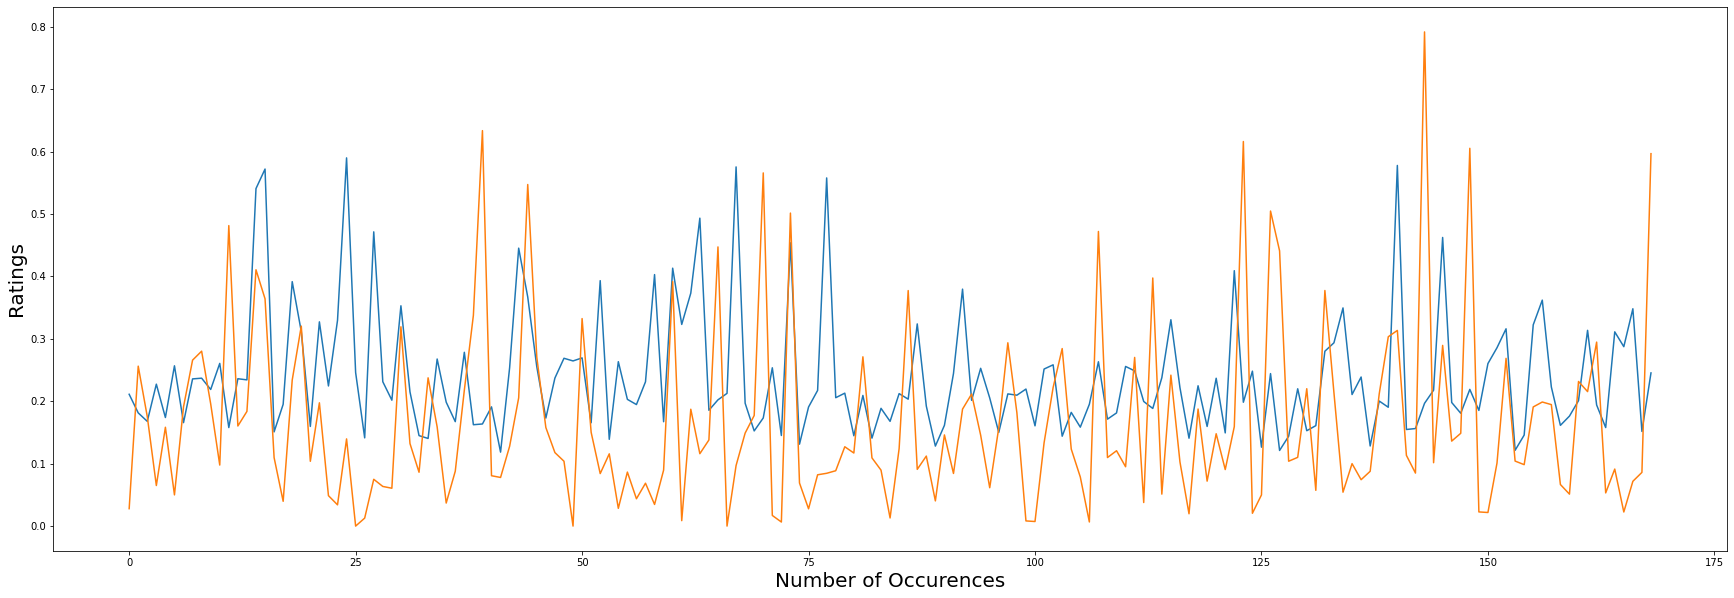

In [110]:
plt.figure(figsize=(30, 10)), plt.plot(model.predict(x_test))
plt.xlabel('Number of Occurences',fontsize=20)
plt.ylabel('Ratings',fontsize=20)
plt.plot(y_test)

# calculating the MSE of Australian domestic batting model

In [111]:
x_predict = model.predict(x_test)
mse = mean_squared_error(x_predict,y_test) 

In [112]:
print('MSE of Australian domestic batting model is', mse)

MSE of Australian domestic batting model is 0.03255353


## Bowling Model

In [113]:
bowling_data['Team'] = "None"
bowling_data['Team'] = bowling_data['Player ID'].apply(lambda x: player_teams[x])

In [114]:
def match_result(match_id, team):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][0] == team:
        return "Won"
    if match_results[match_id][0] == "Draw":
        return "Draw"
    return "Lost"

In [115]:
def is_mom(match_id, player_id):
    if match_id not in match_results.keys():
        return None
    if match_results[match_id][1] == player_id:
        return 1
    return 0

In [116]:
def is_chase(match_id, team):
    result, mom, date, toss_won, toss_selection = match_results[match_id]
    if match_id not in match_results.keys():
        return None
    if team == toss_won and toss_selection == 'field':
        return 1
    if team == toss_won and toss_selection == 'bat':
        return 0
    if team != toss_won and toss_selection == 'field':
        return 0
    if team != toss_won and toss_selection == 'bat':
        return 1
        

In [117]:
bowling_data['10_W'] = bowling_data['W'] + bowling_data['W_2']

In [118]:
bowling_data['10_W'] = bowling_data['10_W'].replace(np.nan, 0)

In [119]:
def ten_haul(row):
    if row['10_W'] >= 10:
        return 1
    if row['10_W'] < 10:
        return 0
    #return 0

In [120]:
def fivehaul_1(row):
     if row['W'] >= 5:
        return 1
     if row['W'] < 5:
        return 0
     return 0

In [121]:
def fivehaul_2(row):
     if row['W_2'] >= 5:
        return 1
     if row['W_2'] < 5:
        return 0
     return 0

In [122]:
bowling_data['10_Haul'] = bowling_data.apply(lambda row: ten_haul(row), axis=1)

In [123]:
bowling_data['5H'] = bowling_data.apply(lambda row: fivehaul_1(row), axis=1)

In [124]:
bowling_data['5H_2'] = bowling_data.apply(lambda row: fivehaul_2(row), axis=1)

In [125]:
bowling_data['Result'] = bowling_data[['Match ID', 'Team']].apply(lambda x: match_result(x[0], x[1]) , axis=1)

In [126]:
bowling_data = bowling_data[bowling_data['Result'].notna()].reset_index(drop=True)

In [127]:
bowling_data['MoM'] = bowling_data[['Match ID', 'Player ID']].apply(lambda x: is_mom(x[0], x[1]) , axis=1)

In [128]:
bowling_data = bowling_data[bowling_data['MoM'].notna()].reset_index(drop=True)

In [129]:
bowling_data['Chase'] = bowling_data[['Match ID', 'Team']].apply(lambda x: is_chase(x[0], x[1]), axis=1)

In [130]:
bowling_data = bowling_data[bowling_data['Chase'].notna()].reset_index(drop=True)

In [131]:
bowling_data['Date'] = bowling_data['Match ID'].apply(lambda x: match_results[x][2] if x in match_results.keys() else None)

In [132]:
bowling_data = bowling_data[bowling_data['Date'].notna()].reset_index(drop=True)

In [133]:
bowling_data.to_excel("results/domestic/australia/bowling.xlsx", index=False)

In [134]:
bowl_X = bowling_data.copy()
del bowl_X['Player Name']
del bowl_X['Team']
del bowl_X['Player URL']

In [135]:
bowl_X = bowl_X.loc[:, ['Player ID', 'Date', 'Result',
       'MoM', 'Chase', '5H', '5H_2', '10_Haul', 'O', 'R', 'W', 'ECON', '0s', '4s', '6s', 'WD', 'NB', 'O_2', 'R_2', 'W_2', 'ECON_2', '0s_2', '4s_2',
       '6s_2', 'WD_2', 'NB_2', ]]

In [136]:
bowl_X = bowl_X.fillna(0)

In [137]:
bowl_X['0s_2'] = bowl_X['0s_2'].replace('-', 0)
bowl_X['0s_2'] = bowl_X['0s_2'].astype(int)
bowl_X['0s'] = bowl_X['0s'].replace('-', 0)
bowl_X['0s'] = bowl_X['0s'].astype(int)

bowl_X['4s_2'] = bowl_X['4s_2'].replace('-', 0)
bowl_X['4s_2'] = bowl_X['4s_2'].astype(int)
bowl_X['4s'] = bowl_X['4s'].replace('-', 0)
bowl_X['4s'] = bowl_X['4s'].astype(int)

bowl_X['6s_2'] = bowl_X['6s_2'].replace('-', 0)
bowl_X['6s_2'] = bowl_X['6s_2'].astype(int)
bowl_X['6s'] = bowl_X['6s'].replace('-', 0)
bowl_X['6s'] = bowl_X['6s'].astype(int)

In [138]:
bowl_X.head(6)

,Player ID,Date,Result,MoM,Chase,5H,5H_2,10_Haul,O,R,...,NB,O_2,R_2,W_2,ECON_2,0s_2,4s_2,6s_2,WD_2,NB_2
0,19,2011-03-10,Lost,0,1,0,0,0,30.0,105,...,3,13.0,43.0,2.0,3.30,0,0,0,0.0,0.0
1,100,2011-03-10,Lost,0,1,0,0,0,19.0,59,...,0,3.0,2.0,0.0,0.66,0,0,0,0.0,0.0
2,33,2011-03-10,Lost,0,1,0,0,0,16.3,48,...,0,13.0,33.0,1.0,2.53,0,0,0,0.0,0.0
3,247,2011-03-10,Lost,0,1,0,0,0,26.0,36,...,0,34.1,56.0,3.0,1.63,0,0,0,0.0,0.0
4,45,2011-03-10,Lost,0,1,0,0,0,15.0,33,...,0,20.0,62.0,1.0,3.10,0,0,0,0.0,0.0
5,95,2011-03-10,Lost,0,1,0,0,0,7.0,21,...,0,15.0,65.0,1.0,4.33,0,0,0,0.0,0.0


In [139]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


In [140]:
mm_bowl = MinMaxScaler()
bowl_X.iloc[:, 5:] = mm_bowl.fit_transform(bowl_X.iloc[:,5:])

In [141]:
result_dict = {'Won': 2, 'Draw': 1, 'Lost': 0}
bowl_X['Result Label'] = bowl_X['Result'].apply(lambda x: result_dict[x])
bowl_X

,Player ID,Date,Result,MoM,Chase,5H,5H_2,10_Haul,O,R,...,O_2,R_2,W_2,ECON_2,0s_2,4s_2,6s_2,WD_2,NB_2,Result Label
0,19,2011-03-10,Lost,0,1,0.0,0.0,0.0,0.483037,0.472973,...,0.250000,0.300699,0.250,0.137500,0.0,0.0,0.0,0.0,0.0,0
1,100,2011-03-10,Lost,0,1,0.0,0.0,0.0,0.305331,0.265766,...,0.057692,0.013986,0.000,0.027500,0.0,0.0,0.0,0.0,0.0,0
2,33,2011-03-10,Lost,0,1,0.0,0.0,0.0,0.261712,0.216216,...,0.250000,0.230769,0.125,0.105417,0.0,0.0,0.0,0.0,0.0,0
3,247,2011-03-10,Lost,0,1,0.0,0.0,0.0,0.418417,0.162162,...,0.655769,0.391608,0.375,0.067917,0.0,0.0,0.0,0.0,0.0,0
4,45,2011-03-10,Lost,0,1,0.0,0.0,0.0,0.240711,0.148649,...,0.384615,0.433566,0.125,0.129167,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755,118,2021-09-24,Draw,0,1,0.0,0.0,0.0,0.418417,0.328829,...,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1
3756,154,2021-09-24,Draw,0,1,0.0,0.0,0.0,0.353796,0.382883,...,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1
3757,41,2021-09-24,Draw,0,1,0.0,0.0,0.0,0.224556,0.306306,...,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1
3758,128,2021-09-24,Draw,0,1,0.0,0.0,0.0,0.337641,0.409910,...,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,1


In [142]:
wickets_factor = 0.6
mom_factor = 0.15 
ten_wikt_factor = 0.125
five_wikt_factor = 0.075
win_factor = 0.025
econ_factor = 0.025

In [143]:
bowl_X['Rating'] = bowl_X['10_Haul'] * ten_wikt_factor + bowl_X['5H'] * five_wikt_factor + bowl_X['5H_2'] * five_wikt_factor + bowl_X['Result Label'] * win_factor +  bowl_X['ECON'] * econ_factor + bowl_X['ECON_2'] * econ_factor + bowl_X['W'] * wickets_factor + bowl_X['W_2'] * wickets_factor

In [144]:
bowling_data['Rating'] = bowl_X['Rating']

In [145]:
test = bowling_data[bowling_data['Player Name'] == 'James Pattinson'].sort_values(by='Rating', ascending=False)

In [146]:
test[['Result', 'Rating',
       'MoM', 'Chase', '5H', '5H_2', '10_Haul', 'O', 'R', 'W', 'ECON', 'O_2', 'R_2', 'W_2', 'ECON_2']]

,Result,Rating,MoM,Chase,5H,5H_2,10_Haul,O,R,W,ECON,O_2,R_2,W_2,ECON_2
880,Lost,0.664621,1,0,0,1,0,12.0,29,2,2.41,14.4,32.0,6.0,2.18
3630,Draw,0.615538,0,0,0,1,0,17.1,32,2,1.86,18.0,71.0,5.0,3.94
1328,Lost,0.524375,1,0,0,1,0,11.0,43,1,3.90,6.0,7.0,5.0,1.16
1356,Lost,0.524025,0,0,0,1,0,13.0,35,1,2.69,21.0,58.0,5.0,2.76
2215,Lost,0.507667,0,1,0,0,0,10.0,30,3,3.00,16.0,41.0,4.0,2.56
2339,Lost,0.458067,0,1,0,1,0,11.0,39,0,3.54,12.0,25.0,5.0,2.08
861,Lost,0.440929,0,0,0,0,0,19.1,56,2,2.92,16.0,42.0,4.0,2.62
3094,Lost,0.439781,0,0,0,0,0,20.0,48,2,2.40,28.0,66.0,4.0,2.35
942,Lost,0.423931,0,0,0,0,0,14.0,30,4,2.14,18.0,64.0,2.0,3.55
3320,Draw,0.389156,0,0,0,0,0,15.0,33,2,2.20,26.0,54.0,3.0,2.07


In [147]:
del bowl_X['Result']

In [148]:
bowl_X.to_csv("results/domestic/australia/traindata_bowling.csv", index=False)

## Training

In [149]:
sequence_length = 10

In [150]:
train_data = []
counts = []
for player_id, indices in bowl_X.groupby('Player ID').indices.items():
    if len(indices) < sequence_length:
        continue
    
    if len(indices) % sequence_length != 0:
        train_data.extend(np.split(bowl_X.loc[indices].sort_values('Date').iloc[:-(len(indices) % sequence_length)].index, len(indices) // sequence_length))
    else:
        train_data.extend(np.split(bowl_X.loc[indices].sort_values('Date').index, len(indices) // sequence_length))
    

In [151]:
train_data = [[bowl_X.loc[idx[:-1]].iloc[:, 2:].values, bowl_X.loc[idx[-1], ['Rating']].values] for idx in train_data]

In [152]:
x = np.array([t[0] for t in train_data])

In [153]:
y = np.array([t[1] for t in train_data])

In [154]:
y_cats = np.digitize(y, np.arange(0,1.1, 0.1))

In [155]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([116,  39,  67,  40,  13,  12,   1,   3,   1,   2], dtype=int64))

In [156]:
for i in reversed(range(len(counts))):
    if i == 0:
        break
    if counts[i] < 2:
        y_cats[y_cats == cats[i]] = cats[i - 1]

In [157]:
cats, counts = np.unique(y_cats, return_counts=True)
cats, counts

(array([ 1,  2,  3,  4,  5,  6,  8, 10], dtype=int64),
 array([116,  39,  67,  40,  13,  13,   4,   2], dtype=int64))

In [158]:
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.3, stratify=y_cats)

In [159]:
y_train_labels = np.digitize(y_train, np.arange(0,1.1, 0.1))

In [160]:
y_train_cats, y_train_counts = np.unique(y_train_labels, return_counts=True)

In [161]:
y_train_cats, y_train_counts

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([81, 27, 47, 28,  9,  8,  1,  2,  1,  1], dtype=int64))

In [162]:
y_train_max_class = y_train_cats[np.argmax(y_train_counts)]
y_train_max_count = np.max(y_train_counts)
y_train_max_class, y_train_max_count

(1, 81)

In [163]:
final_train_x = []
final_train_y = []
for cat, counts in zip(y_train_cats, y_train_counts):
    if cat == y_train_max_class:
        continue
    idx = np.argwhere(y_train_labels.flatten() == cat).flatten()
    
    upsampled_idx = resample(idx, replace=True, n_samples=y_train_max_count)
    
    final_train_x.extend(x_train[upsampled_idx])
    final_train_y.extend(y_train[upsampled_idx])

In [164]:
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [165]:
final_train_x.shape

(729, 9, 25)

In [166]:
model = keras.Sequential()

model.add(keras.layers.LSTM(256, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(128, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(64, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(sequence_length-1, final_train_x.shape[-1]), kernel_initializer='he_normal', return_sequences=False))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 9, 256)            288768    
                                                                 
 lstm_5 (LSTM)               (None, 9, 128)            197120    
                                                                 
 lstm_6 (LSTM)               (None, 9, 64)             49408     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 547,745
Trainable params: 547,745
Non-trainable params: 0
_________________________________________________________________


In [167]:
save_best = keras.callbacks.ModelCheckpoint("./results/domestic/australia/bowling.h5", save_best_only=True)

In [168]:
model.fit(final_train_x, final_train_y, epochs=500, verbose=1, validation_data=(x_test, y_test), callbacks=[save_best])


Epoch 1/500
23/23 [==============================] - 25s 255ms/step - loss: 0.2019 - val_loss: 0.1755
Epoch 2/500
23/23 [==============================] - 2s 66ms/step - loss: 0.1140 - val_loss: 0.2045
Epoch 3/500
23/23 [==============================] - 2s 69ms/step - loss: 0.0783 - val_loss: 0.1695
Epoch 4/500
23/23 [==============================] - 2s 74ms/step - loss: 0.0661 - val_loss: 0.1701
Epoch 5/500
23/23 [==============================] - 2s 76ms/step - loss: 0.0482 - val_loss: 0.1827
Epoch 6/500
23/23 [==============================] - 1s 65ms/step - loss: 0.0457 - val_loss: 0.1875
Epoch 7/500
23/23 [==============================] - 2s 74ms/step - loss: 0.0381 - val_loss: 0.1723
Epoch 8/500
23/23 [==============================] - 2s 79ms/step - loss: 0.0341 - val_loss: 0.1638
Epoch 9/500
23/23 [==============================] - 2s 71ms/step - loss: 0.0353 - val_loss: 0.1782
Epoch 10/500
23/23 [==============================] - 2s 78ms/step - loss: 0.0388 - val_loss: 0.18

23/23 [==============================] - 2s 85ms/step - loss: 0.0067 - val_loss: 0.1633
Epoch 83/500
23/23 [==============================] - 2s 77ms/step - loss: 0.0059 - val_loss: 0.1635
Epoch 84/500
23/23 [==============================] - 2s 77ms/step - loss: 0.0071 - val_loss: 0.1747
Epoch 85/500
23/23 [==============================] - 2s 73ms/step - loss: 0.0077 - val_loss: 0.1682
Epoch 86/500
23/23 [==============================] - 2s 91ms/step - loss: 0.0073 - val_loss: 0.1610
Epoch 87/500
23/23 [==============================] - 2s 84ms/step - loss: 0.0071 - val_loss: 0.1749
Epoch 88/500
23/23 [==============================] - 2s 87ms/step - loss: 0.0058 - val_loss: 0.1668
Epoch 89/500
23/23 [==============================] - 2s 77ms/step - loss: 0.0070 - val_loss: 0.1615
Epoch 90/500
23/23 [==============================] - 2s 83ms/step - loss: 0.0086 - val_loss: 0.1637
Epoch 91/500
23/23 [==============================] - 2s 73ms/step - loss: 0.0082 - val_loss: 0.1617
Epo

23/23 [==============================] - 2s 88ms/step - loss: 0.0053 - val_loss: 0.1689
Epoch 163/500
23/23 [==============================] - 2s 86ms/step - loss: 0.0055 - val_loss: 0.1647
Epoch 164/500
23/23 [==============================] - 2s 79ms/step - loss: 0.0047 - val_loss: 0.1686
Epoch 165/500
23/23 [==============================] - 2s 84ms/step - loss: 0.0063 - val_loss: 0.1572
Epoch 166/500
23/23 [==============================] - 2s 78ms/step - loss: 0.0053 - val_loss: 0.1673
Epoch 167/500
23/23 [==============================] - 2s 76ms/step - loss: 0.0054 - val_loss: 0.1625
Epoch 168/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0049 - val_loss: 0.1661
Epoch 169/500
23/23 [==============================] - 2s 69ms/step - loss: 0.0044 - val_loss: 0.1664
Epoch 170/500
23/23 [==============================] - 2s 77ms/step - loss: 0.0051 - val_loss: 0.1661
Epoch 171/500
23/23 [==============================] - 2s 72ms/step - loss: 0.0037 - val_loss: 0

23/23 [==============================] - 2s 76ms/step - loss: 0.0041 - val_loss: 0.1702
Epoch 243/500
23/23 [==============================] - 2s 84ms/step - loss: 0.0043 - val_loss: 0.1720
Epoch 244/500
23/23 [==============================] - 2s 80ms/step - loss: 0.0047 - val_loss: 0.1689
Epoch 245/500
23/23 [==============================] - 2s 78ms/step - loss: 0.0036 - val_loss: 0.1601
Epoch 246/500
23/23 [==============================] - 2s 82ms/step - loss: 0.0048 - val_loss: 0.1733
Epoch 247/500
23/23 [==============================] - 2s 76ms/step - loss: 0.0043 - val_loss: 0.1569
Epoch 248/500
23/23 [==============================] - 2s 76ms/step - loss: 0.0039 - val_loss: 0.1770
Epoch 249/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0032 - val_loss: 0.1766
Epoch 250/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0030 - val_loss: 0.1642
Epoch 251/500
23/23 [==============================] - 2s 79ms/step - loss: 0.0038 - val_loss: 0

23/23 [==============================] - 2s 78ms/step - loss: 0.0029 - val_loss: 0.1689
Epoch 323/500
23/23 [==============================] - 2s 73ms/step - loss: 0.0034 - val_loss: 0.1625
Epoch 324/500
23/23 [==============================] - 2s 72ms/step - loss: 0.0042 - val_loss: 0.1730
Epoch 325/500
23/23 [==============================] - 2s 74ms/step - loss: 0.0036 - val_loss: 0.1716
Epoch 326/500
23/23 [==============================] - 2s 75ms/step - loss: 0.0034 - val_loss: 0.1666
Epoch 327/500
23/23 [==============================] - 2s 74ms/step - loss: 0.0033 - val_loss: 0.1699
Epoch 328/500
23/23 [==============================] - 2s 68ms/step - loss: 0.0026 - val_loss: 0.1639
Epoch 329/500
23/23 [==============================] - 2s 69ms/step - loss: 0.0022 - val_loss: 0.1643
Epoch 330/500
23/23 [==============================] - 2s 71ms/step - loss: 0.0027 - val_loss: 0.1548
Epoch 331/500
23/23 [==============================] - 1s 65ms/step - loss: 0.0036 - val_loss: 0

23/23 [==============================] - 2s 71ms/step - loss: 0.0020 - val_loss: 0.1700
Epoch 403/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0023 - val_loss: 0.1782
Epoch 404/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0027 - val_loss: 0.1800
Epoch 405/500
23/23 [==============================] - 2s 66ms/step - loss: 0.0024 - val_loss: 0.1756
Epoch 406/500
23/23 [==============================] - 2s 69ms/step - loss: 0.0022 - val_loss: 0.1742
Epoch 407/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0030 - val_loss: 0.1710
Epoch 408/500
23/23 [==============================] - 2s 68ms/step - loss: 0.0029 - val_loss: 0.1766
Epoch 409/500
23/23 [==============================] - 2s 68ms/step - loss: 0.0026 - val_loss: 0.1779
Epoch 410/500
23/23 [==============================] - 1s 64ms/step - loss: 0.0020 - val_loss: 0.1742
Epoch 411/500
23/23 [==============================] - 2s 68ms/step - loss: 0.0018 - val_loss: 0

23/23 [==============================] - 2s 68ms/step - loss: 0.0023 - val_loss: 0.1768
Epoch 483/500
23/23 [==============================] - 1s 62ms/step - loss: 0.0019 - val_loss: 0.1758
Epoch 484/500
23/23 [==============================] - 2s 66ms/step - loss: 0.0027 - val_loss: 0.1783
Epoch 485/500
23/23 [==============================] - 2s 73ms/step - loss: 0.0024 - val_loss: 0.1799
Epoch 486/500
23/23 [==============================] - 1s 65ms/step - loss: 0.0026 - val_loss: 0.1763
Epoch 487/500
23/23 [==============================] - 2s 67ms/step - loss: 0.0022 - val_loss: 0.1788
Epoch 488/500
23/23 [==============================] - 2s 70ms/step - loss: 0.0020 - val_loss: 0.1755
Epoch 489/500
23/23 [==============================] - 1s 63ms/step - loss: 0.0025 - val_loss: 0.1780
Epoch 490/500
23/23 [==============================] - 1s 65ms/step - loss: 0.0033 - val_loss: 0.1720
Epoch 491/500
23/23 [==============================] - 1s 64ms/step - loss: 0.0024 - val_loss: 0

In [169]:
model = keras.models.load_model("./results/domestic/australia/bowling.h5")

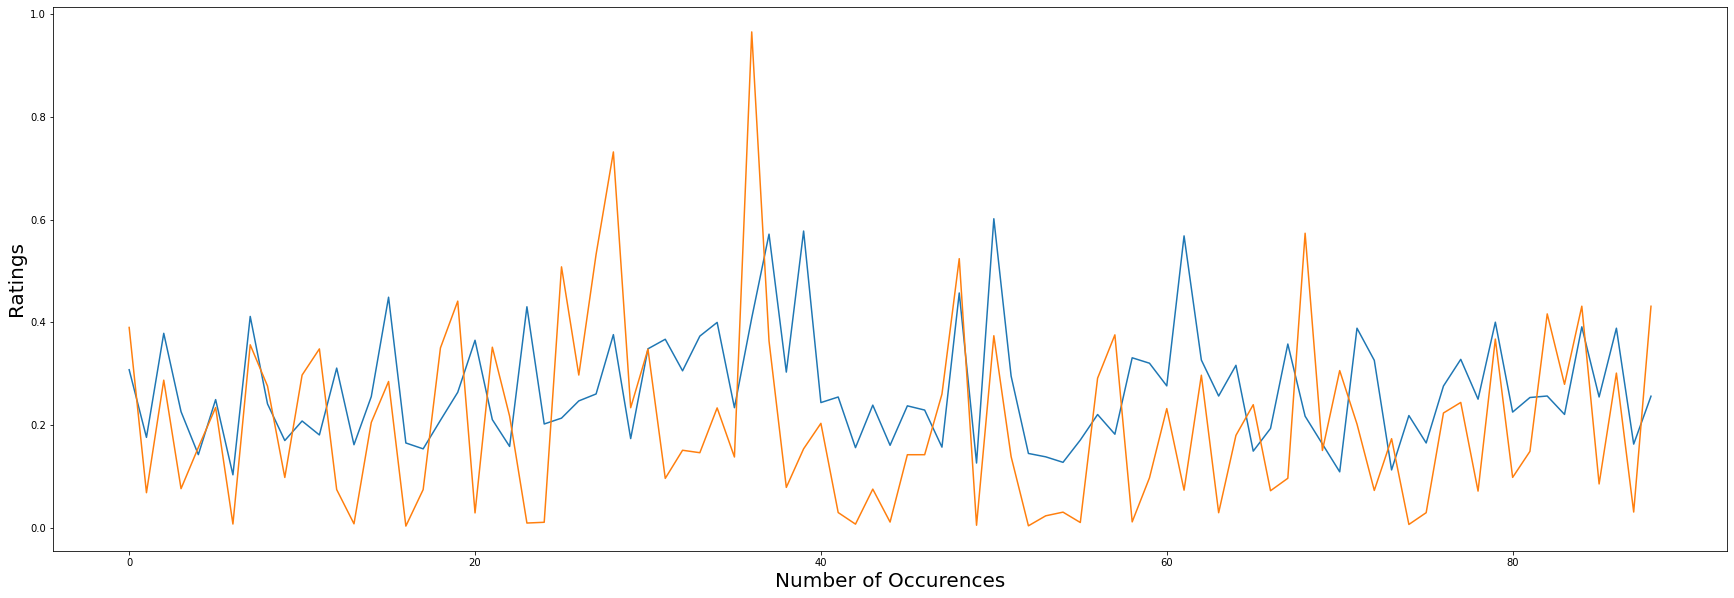

In [170]:
plt.figure(figsize=(30, 10)), plt.plot(model.predict(x_test))
plt.xlabel('Number of Occurences',fontsize=20)
plt.ylabel('Ratings',fontsize=20)
plt.plot(y_test)

# calculating the MSE Australian domestic bowling model

In [171]:
x_predict = model.predict(x_test)
mse = mean_squared_error(x_predict,y_test) 

In [172]:
print('MSE of Australian domestic bowling model is', mse)

MSE of Australian domestic bowling model is 0.035318132
